# **Anomaly Detection: Esempio di Applicazione Industriale (pt. 1)**

L'obiettivo di notebook è quello di analizzare un problema reale di controllo qualità all'interno di una catena di montaggio automatica e di proporre un modello di Machine Learning in grado elaborare le immagini dei pezzi prodotti al fine di riconoscere quelli difettosi.



## **Analisi del Dataset**

Il dataset iniziale è composto da un totale di 132 esempi così suddivisi:

- 101 immagini di pezzi "normali" detti anche OK
- 21 immagini di pezzi difettosi detti anche KO

Ogni immagine raffigura un tubo di acciaio sul quale sono applicate 2 clip metalliche, i pezzi KO sono caratterizzati dall'assenza di una di queste.

![](images/esempio_pezzi.png)

**Attenzione**: Il tubo in acciaio non è sempre centrato all'interno dell'immagine, questo infatti è soggetto a *tolleranze di posizione e rotazione*, a causa delle imperfezioni delle saldature.

## **Formulazione del problema**

Il dataset a disposizione mostra un forte sbilanciamento in favore degli esempi di pezzi OK, mentre la classe KO risulta poco rappresentata.

Al fine di poter proporre un moello che sia meno sensibile a tale sbilanciamento, si vuole formulare il problema come un caso di Anomaly Detection, per cui le immagini di pezzi OK rappresentano l'insieme di dati considerati normali, mentre i pezzi KO rappresentano le anomalie che si vogliono identificare.

## **Caricamento delle immagini**

Al fine di semplificare la gestione dei dati durante il processo di addestramento e valutazione del modello, le immagini che compongono il dataset iniziali sono organizzate in 3 sotto-gruppi:

- 91 esempi di pezzi OK compongono l'insieme di dati riservati al training del modello
- le restanti 10 immagini di pezzi OK verranno utilizzate per i test successivi all'addestramento
- i 21 esempi di KO compogono un dataset a parte.

In [1]:
import os, random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path = "dataset/clip_dataset"

Mostriamo qualche esempio a disposizione.

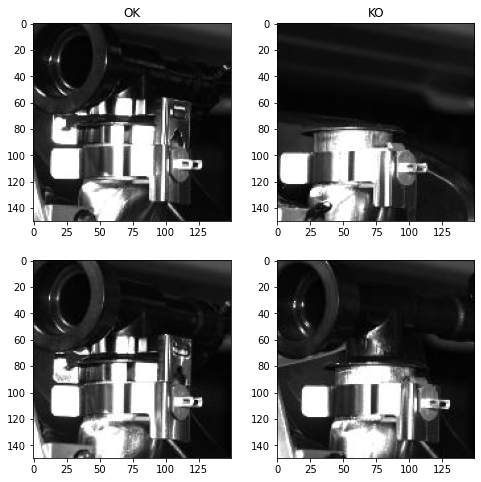

In [3]:
n_samples = 2

_, axs = plt.subplots(n_samples, 2, figsize=(8,8))
axs = axs.flatten()

samples = []

for i in range(n_samples):

  filename = random.choice(os.listdir(data_path + "/train/OK"))
  filename = os.path.join(data_path + "/train/OK", filename)

  with Image.open(filename) as test_ok:
    img_size = test_ok.size
    img = np.array(test_ok)
    img.reshape(img_size)
    samples.append(img)


  filename = random.choice(os.listdir(data_path + "/anomalies/KO"))
  filename = os.path.join(data_path + "/anomalies/KO", filename)

  with Image.open(filename) as test_ko:
    img_size = test_ko.size
    img = np.array(test_ko)
    img.reshape(img_size)
    samples.append(img)

axs[0].set_title("OK")
axs[1].set_title("KO")

for sample, ax in zip(samples, axs):
    ax.imshow(sample, cmap="gray")

plt.show()

Carichiamo le immagini secondo la suddivisione nei 3 sotto-dataset.

Dal momento in cui il numero di esempi per il training del modello è limitato, possiamo sfruttare le tolleranze di posizione e rotazione del tubo per generare, per mezzo di funzioni di Data Augmentation, degli ulteriori esempi verosimili.

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
batch_size = 8

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range = 5.0,
                                   width_shift_range = 0.05,
                                   height_shift_range = 0.05,
                                   validation_split = 0.1) # Data Augmentation
# Generatore di immagini di training dei pezzi OK
train_generator = train_datagen.flow_from_directory(
    data_path + "/train",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode='input',
    subset = "training" )
# Generatore di immagini di validazione dei pezzi OK
valid_generator = train_datagen.flow_from_directory(
    data_path + "/train",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode='input',
    subset = "validation" )


test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# Generatore di immagini di test di pezzi OK
test_generator = test_datagen.flow_from_directory(
    data_path + "/test",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode='input' )

anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# Generatore di immagini di test di pezzi KO 
anomaly_generator = anomaly_datagen.flow_from_directory(
    data_path + "/anomalies",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode='input' )

Found 82 images belonging to 1 classes.
Found 9 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


## **Implementazione del Modello**

Il modello scelto per la risoluzione del problema consiste in un Autoencoder convolutivo di tipo U-NET.

Il vantaggio di questa tipologia di rete è che la fase di addestramento richiede l'utilizzo dei soli esempi di dati normali.

Ottimizzando il modello esclusivamente per la ricostruzione dei pezzi OK, ci si aspetta che, una volta completato l'addestramento, l'errore di ricostruzione sulle immagini di questi sia sensibilmente minore rispetto all'errore commesso sulle anomalie, consentendone così il riconoscimento.

### **Definizione**

In [6]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, Dense, Reshape, Flatten
from keras.models import Model
from keras.layers import concatenate
from keras.models import load_model

Definiamo una funzione di utilità per l'implementazione di una rete U-NET

In [7]:
def get_UNET(input_shape = (128, 128, 1)):
  # ----- INPUT LAYER -----
  
  inputs = Input(shape=input_shape)

  # ----- ENCODER -----

  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same')(inputs)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same')(pool1)
  conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(8, 3, activation = 'relu', padding = 'same')(pool2)
  conv3 = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(8, 3, activation = 'relu', padding = 'same')(pool3)
  conv4 = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  drop4 = Dropout(0.3)(pool4)

  # ----- DECODER -----

  up6 = (UpSampling2D(size = (2,2))(drop4))
  merge6 = concatenate([conv4,up6], axis = 3) 
  conv6 = Conv2D(8, 3, activation = 'relu', padding = 'same')(merge6)
  conv6 = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv6)

  up7 = (UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(8, 3, activation = 'relu', padding = 'same')(merge7)
  conv7 = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv7)

  up8 = (UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same')(merge8)
  conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same')(conv8)

  up9 = (UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same')(merge9)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same')(conv9)

  # ----- OUTPUT LAYER -----

  conv10 = Conv2D(1, 3, activation = 'sigmoid', padding='same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  model.compile(optimizer='adam', loss='mse')

  return model

Utilizzare l'**Errore Quadratico Medio** (MSE) come funzione di costo, garantisce che durante l'addestramnento il modello venga ottimizzato per ricostruire il più fedelmente possibile le immagini in input.

In [8]:
unet = get_UNET()

unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### **Training**

Procediamo con l'addestramento della rete.

In [ ]:
train_generator.reset()
test_generator.reset()

history = unet.fit(train_generator,
          steps_per_epoch=10,
          epochs=30,
          validation_data=valid_generator,
          validation_steps=1,
          shuffle = True)

Epoch 1/30
10/10 [==============================] - 10s 789ms/step - loss: 0.1518 - val_loss: 0.1159
Epoch 2/30
10/10 [==============================] - 7s 704ms/step - loss: 0.0814 - val_loss: 0.0156
Epoch 3/30
10/10 [==============================] - 7s 704ms/step - loss: 0.0147 - val_loss: 0.0074
Epoch 4/30
10/10 [==============================] - 8s 757ms/step - loss: 0.0069 - val_loss: 0.0050
Epoch 5/30
10/10 [==============================] - 7s 705ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 6/30
10/10 [==============================] - 7s 701ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 7/30
10/10 [==============================] - 7s 706ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 8/30
10/10 [==============================] - 7s 711ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 9/30
10/10 [==============================] - 7s 710ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/30
10/10 [==============================] - 7s 703ms/step - loss: 0.0021 - val_loss: 0.001

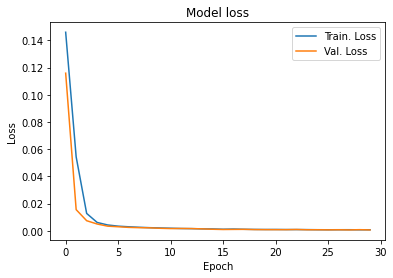

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train. Loss', 'Val. Loss'], loc='upper right')
plt.show()

In [ ]:
unet.save("Clip_Anomaly_Det_UNET.h5")

## **Risultati Ottenuti**

Analizziamo il comportamento del modello sui dataset di test e valutiamone l'efficacia.

Per mantenere la coerenza tra le affermazioni riportate ed il risultato dell'esecuzione del codice, utilizziamo un modello pre-addestrato.


In [10]:
from keras.models import load_model

In [11]:
model_path = "models/Clip_Anomaly_Det_UNET.h5"

unet = load_model(model_path)
unet.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 128, 128, 16) 160         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_136[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_137[0][0]                 
____________________________________________________________________________________________

Osserviamo prima di tutto i risultati della ricostruzione delle immagini.

In [12]:
def plot_rec_samples(image_generator, autoencoder, n):
    batch = image_generator.next()[0]

    predicted = autoencoder.predict(batch)
    _, axs = plt.subplots(n, 2, figsize=(8, 8))
    axs = axs.flatten()
    imgs = []

    for i in range(n):
        imgs.append(batch[i])
        imgs.append(predicted[i])

    for img, ax in zip(imgs, axs):
        img = img.reshape((128, 128))
        ax.imshow(img, cmap="gray")
    plt.show()

Esempio di ricostruzione su pezzi OK


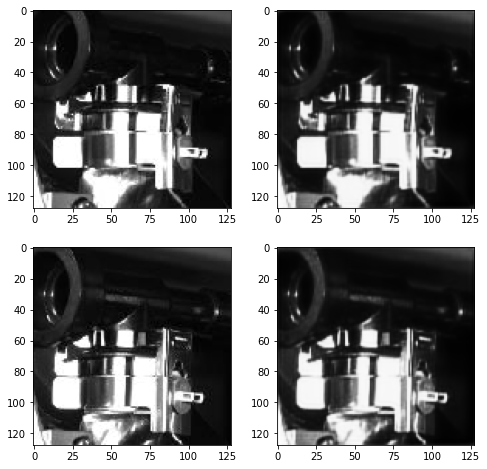

Esempio di ricostruzione su pezzi KO


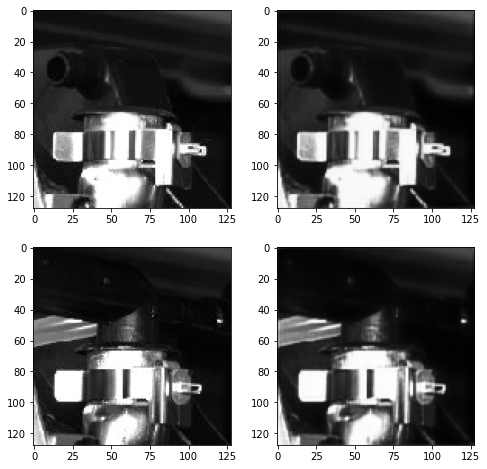

In [13]:
print("Esempio di ricostruzione su pezzi OK")
plot_rec_samples(test_generator, unet, 2)

print("Esempio di ricostruzione su pezzi KO")
plot_rec_samples(anomaly_generator, unet, 2)

Il modello così addestrato è in grado di ricostruire molto accuratamente sia le immagini di pezzi buoni, sia le immagini di pezzi scarto.

Tuttavia analizzando gli errori di ricostruzione si nota un comportamento inatteso.

In [14]:
def plot_rec_error(image_generator, autoencoder, n = None):

  '''
  Mostra su grafico gli errori di ricostruzione di n immagini ottenute da un generatore.
  '''
    
  if n == None:
    n = image_generator.samples

  error_list = []
  processed = 0

  while processed < n:
    batch = image_generator.next()[0]
    for i in range(len(batch)):
        img = batch[i]
        img = img.reshape((1,128,128,1))
        # Calcolo dell'immagine ricostruita
        rec = autoencoder.predict(img)
        # Calcolo dell'Errore Quadratico Medio
        error = np.square(rec - img).mean()
        error_list.append(error)

        processed += 1

  print("min error:", min(error_list))
  print("max error:", max(error_list))

  plt.scatter(x = range(len(error_list)), y = sorted(error_list))
  plt.show()
  return error_list

Errore di ricostruzione su pezzi OK
min error: 0.0011470637
max error: 0.0013175812


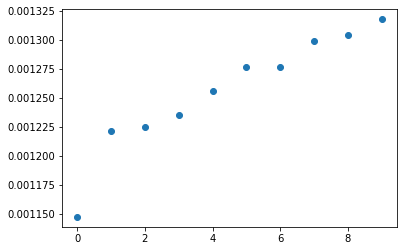

In [15]:
print("Errore di ricostruzione su pezzi OK")

test_generator.reset()
ok_err = plot_rec_error(test_generator, unet)

Errore di ricostruzione su pezzi KO
min error: 0.00082733814
max error: 0.001001121


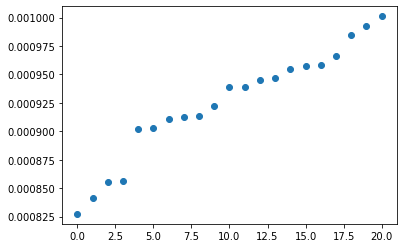

In [16]:
print("Errore di ricostruzione su pezzi KO")

anomaly_generator.reset()
ko_err = plot_rec_error(anomaly_generator, unet)

Al contrario di quanto ci si aspettava di ottenere, l'errore commesso sulle immagini anomale risulta sensibilmente inferiore rispetto a quello commesso sui pezzi normali.

Le performance del modello non migliorano se utilizziamo immagini traslate e ruotate.


In [18]:
augmented_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=5.0, 
                                                                               width_shift_range=0.05, 
                                                                               height_shift_range=0.05)
augmented_test_generator = augmented_test_datagen.flow_from_directory(
    data_path + "/test",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale")

augmented_anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=5.0, 
                                                                                  width_shift_range=0.05, 
                                                                                  height_shift_range=0.05)
augmented_anomaly_generator = augmented_anomaly_datagen.flow_from_directory(
    data_path + "/anomalies",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale" )

Found 10 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


Anche in questo caso l'errore di ricostruzione risulta inferiore in caso di immagini di pezzi KO.

Errore di ricostruzione su pezzi OK
min error: 0.0005604394
max error: 0.0010224982


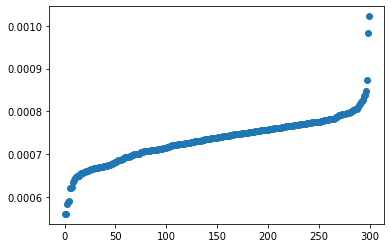

In [21]:
print("Errore di ricostruzione su pezzi OK")

augmented_test_generator.reset()
ok_err = plot_rec_error(augmented_test_generator, unet, 300)

Errore di ricostruzione su pezzi KO
min error: 0.00049558975
max error: 0.0007787706


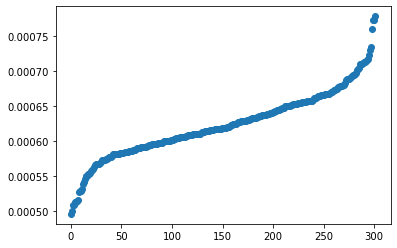

In [22]:
print("Errore di ricostruzione su pezzi KO")

augmented_anomaly_generator.reset()
ko_err = plot_rec_error(augmented_anomaly_generator, unet, 300)

In conclusione, il modello non permette di determinare una soglia di errore che consenta di distinguere in modo significativo tra le due categorie di immagini, pertanto non è adatto allarisoluzione del problema posto inizialmente.